In [1]:
!pip install fastFM

You are using pip version 9.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Upload kaggle.json and run this if you run the notebook on colab

In [2]:
!mkdir /root/.kaggle
!cp kaggle.json /root/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: Permission denied
cp: failed to access '/root/.kaggle': Permission denied


In [3]:
import os
import numpy as np
import shutil
import seaborn as sns
import scipy

import pandas as pd

from livelossplot import PlotLosses
import matplotlib.pyplot as plt

import sklearn
import sklearn.compose
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold

import fastFM.als
import fastFM.sgd
import fastFM.mcmc


import tqdm

from kaggle.api.kaggle_api_extended import KaggleApi
from kaggle.api_client import ApiClient

In [4]:
plt.style.use('dark_background')

In [5]:
def preprocess_game_info_df(game_info_df):
  game_info_df['Genre'] = game_info_df['Genre'].str.replace(' ', '-').str.replace(';', ' ')
  # game_info_df = game_info_df[game_info_df['Platform'] == 'PC']
  game_info_df['Metascore'][game_info_df['Metascore'] == 'not specified'] = 'nan'
  game_info_df['Metascore'] = game_info_df['Metascore'].astype('float') / 100
  game_info_df['Metascore'] = game_info_df['Metascore'].fillna(game_info_df['Metascore'].mean(skipna=True))
  game_info_df['Avg_Userscore'][game_info_df['Avg_Userscore'] == 'tbd'] = 8
  game_info_df['Avg_Userscore'][game_info_df['Avg_Userscore'] == 'not specified'] = 'nan'
  game_info_df['Avg_Userscore'] = game_info_df['Avg_Userscore'].astype('float') / 10
  game_info_df['Avg_Userscore'] = game_info_df['Avg_Userscore'].fillna(game_info_df['Avg_Userscore'].mean(skipna=True))
  return game_info_df


def preprocess_game_comments_df(game_comments_df):
  game_comments_df = pd.read_csv('metacritic_game_user_comments.csv', index_col=0)
  # game_comments_df = game_comments_df[game_comments_df['Platform'] == 'PC']
  return game_comments_df[~game_comments_df['Username'].isna()]

In [6]:
def get_column_inverse_norms(X, tol=1e-5):
    features_matrix_maxes = X.max(axis=0).toarray()
    features_matrix_maxes[np.abs(features_matrix_maxes) < tol] = 1
    return scipy.sparse.spdiags(1.0 / features_matrix_maxes, 0, features_matrix_maxes.shape[1], features_matrix_maxes.shape[1])


def column_normalize_csr_matrix(X, inverse_norms):
    return scipy.sparse.csr_matrix(X @ inverse_norms)

In [7]:
def add_label_encoded_column(df, colname, col_le=None):
  if col_le is None:
    col_le = LabelEncoder().fit(df[colname])
  df[colname + '_label_ID'] = col_le.transform(df[colname])
  return df, col_le


def get_rating_matrix(df, n_items):
  n_users = df['Username_label_ID'].max() + 1
  return scipy.sparse.csr_matrix((df['Userscore'], (df['Username_label_ID'], df['Title_label_ID'])), shape=(n_users, n_items))

In [8]:
def map_dict(rating_dict, username='me'):
  title_ids = title_le.transform(list(rating_dict.keys()))
  raw_df = pd.DataFrame.from_records([{'Username': username, 'Title': title, 'Title_label_ID': title_id, 'Userscore': score} for (title_id, (title, score)) in zip(title_ids, rating_dict.items())])
  return raw_df


def get_ratings_matrix_from_ratings_dict(ratings_df, comments_df, title_le):
  ratings_df['Username_label_ID'] = 0
  return get_rating_matrix(ratings_df, comments_df['Title_label_ID'].max() + 1)

### Genre features for users



In [9]:
def make_user_game_vectorizer(primary_columns=['Title_label_ID', 'Username_label_ID', 'Platform'], selected_columns=['Metascore', 'Avg_Userscore']):
    column_encoders = [(col, OneHotEncoder(categories='auto'), [col]) for col in primary_columns]
    column_selectors = [(col, StandardScaler(), [col]) for col in selected_columns]
    return sklearn.compose.ColumnTransformer(column_encoders + column_selectors)

In [10]:
default_fm_hyperparams = dict(init_stdev=0.01, rank=50, l2_reg_w=5.0, l2_reg_V=8.0)


def setup_fm(fm_hyperparams):
    return fastFM.als.FMRegression(n_iter=1, **fm_hyperparams)


def train_fm(
        X_train,
        y_train,
        X_test,
        y_test,
        n_iter=25,
        step_size=1,
        fm_hyperparams=default_fm_hyperparams,
        early_stopping=True):
    fm = setup_fm(default_fm_hyperparams)
    fm.fit(X_train, y_train)
    
    liveplot = PlotLosses()

    for i in tqdm.tqdm(range(1, n_iter)):
        fm.fit(X_train, y_train, n_more_iter=1)
        y_pred = fm.predict(X_test)

        liveplot.update({
            'rmse': np.sqrt(mean_squared_error(fm.predict(X_train), y_train)),
            'val_rmse': np.sqrt(mean_squared_error(fm.predict(X_test), y_test)),
            'mae': mean_absolute_error(fm.predict(X_train), y_train),
            'val_mae': mean_absolute_error(fm.predict(X_test), y_test)
        })
        liveplot.draw()
        
    return fm


def train_mcmc_fm(
        X_train,
        y_train,
        X_test,
        y_test,
        n_iter=25,
        step_size=1,
        init_stdev=0.1,
        rank=50,
        early_stopping=True,
        early_stopping_rounds=10):
    fm = fastFM.mcmc.FMRegression(n_iter=1, rank=rank, init_stdev=init_stdev)
    fm.fit_predict(X_train, y_train, X_test)
    
    liveplot = PlotLosses()
    plt.style.use('dark_background')

    tqdm_iter = tqdm.tqdm(range(1, n_iter))
    for i in tqdm_iter:
        y_pred = fm.fit_predict(X_train, y_train, X_test, n_more_iter=1)

        current_val_metric = np.sqrt(mean_squared_error(fm.predict(X_test), y_test))
        liveplot.update({
            'rmse': np.sqrt(mean_squared_error(fm.predict(X_train), y_train)),
            'val_rmse': current_val_metric,
            'mae': mean_absolute_error(fm.predict(X_train), y_train),
            'val_mae': mean_absolute_error(fm.predict(X_test), y_test)
        })
        liveplot.draw()
        checked_last_steps = [item['rmse'] for item in liveplot.logs[:-early_stopping_rounds]]
        if len(checked_last_steps) > 0 and min(checked_last_steps) < current_val_metric:
            tqdm_iter.close()
            break
        
    return fm

In [11]:
api = KaggleApi(ApiClient())
api.authenticate()
if not os.path.exists('metacritic-video-game-comments.zip'):
    api.dataset_download_files(dataset='dahlia25/metacritic-video-game-comments', unzip=True)

In [12]:
!head metacritic_game_info.csv

,Title,Year,Publisher,Genre,Platform,Metascore,Avg_Userscore,No_Players
0,The Legend of Zelda: Ocarina of Time,1998,Nintendo,Action Adventure;Fantasy,Nintendo64,99,9.1,1 Player
1,Tony Hawk's Pro Skater 2,2000,NeversoftEntertainment,Sports;Alternative;Skateboarding,PlayStation,98,7.4,1-2 
2,Grand Theft Auto IV,2008,RockstarNorth,Action Adventure;Modern;Modern;Open-World,PlayStation3,98,7.5,1 Player
3,SoulCalibur,1999,Namco,Action;Fighting;3D,Dreamcast,98,8.6,1-2 
4,Grand Theft Auto IV,2008,RockstarNorth,Action Adventure;Modern;Modern;Open-World,Xbox360,98,7.9,1 Player
5,Super Mario Galaxy,2007,Nintendo,Action;Platformer;Platformer;3D;3D,Wii,97,9.0,No Online Multiplayer
6,Super Mario Galaxy 2,2010,NintendoEADTokyo,Action;Platformer;Platformer;3D;3D,Wii,97,9.1,No Online Multiplayer
7,Grand Theft Auto V,2014,RockstarNorth,Action Adventure;Modern;Open-World,XboxOne,97,7.8,Up to 30 
8,Grand Theft Auto V,2013,RockstarNorth,Modern;Action Adventure;Modern;Open-World,PlayStation3,97,8.3,Up to 16

In [13]:
game_comments_df = pd.read_csv('metacritic_game_user_comments.csv', index_col=0)
game_comments_df = preprocess_game_comments_df(game_comments_df)

In [14]:
game_info_df = pd.read_csv('metacritic_game_info.csv', index_col=0)
game_info_df = preprocess_game_info_df(game_info_df)
game_info_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 8 columns):
Title            5000 non-null object
Year             5000 non-null object
Publisher        5000 non-null object
Genre            5000 non-null object
Platform         5000 non-null object
Metascore        5000 non-null float64
Avg_Userscore    5000 non-null float64
No_Players       4993 non-null object
dtypes: float64(2), object(6)
memory usage: 351.6+ KB


/home/kuba/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/kuba/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
users_index = game_comments_df['Username'].unique()
titles_index = game_info_df['Title'].values

from sklearn.preprocessing import LabelEncoder
users_le = LabelEncoder().fit(users_index)
titles_le = LabelEncoder().fit(titles_index)

In [16]:
game_comments_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283980 entries, 0 to 283982
Data columns (total 5 columns):
Title        283980 non-null object
Platform     283980 non-null object
Userscore    283980 non-null int64
Comment      283957 non-null object
Username     283980 non-null object
dtypes: int64(1), object(4)
memory usage: 13.0+ MB


In [17]:
game_comments_df.describe()

,Userscore
count,283980.000000
mean,7.618329
std,3.131772
min,0.000000
25%,7.000000
50%,9.000000
75%,10.000000
max,10.000000


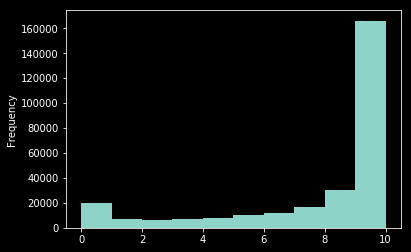

In [18]:
game_comments_df['Userscore'].plot.hist();

In [19]:
game_genre = game_info_df['Genre'].str.replace(';', ' ')

In [20]:
len(game_info_df['Title'].unique())

3438

In [21]:
game_info_df['Title'].head()

0    The Legend of Zelda: Ocarina of Time
1                Tony Hawk's Pro Skater 2
2                     Grand Theft Auto IV
3                             SoulCalibur
4                     Grand Theft Auto IV
Name: Title, dtype: object

In [22]:
titles_index = pd.Index(game_info_df['Title'].values)

In [23]:
game_comments_df.shape

(283980, 5)

## Restrict titles to these that have reviews

In [24]:
def get_column_values_with_min_occurrences(df, col, min_occurrences=4):
    col_value_counts = df[col].value_counts()
    return col_value_counts[col_value_counts >= min_occurrences].index

In [25]:
user_comment_counts = game_comments_df['Username'].value_counts()
title_counts = game_comments_df['Title'].value_counts()

more_than_one_comment_game_comments_df = game_comments_df[
    game_comments_df['Title'].isin(get_column_values_with_min_occurrences(game_comments_df, 'Title')) &
    game_comments_df['Username'].isin(get_column_values_with_min_occurrences(game_comments_df, 'Username'))
]

In [26]:
game_info_df = game_info_df[game_info_df['Title'].isin(more_than_one_comment_game_comments_df['Title'])]
game_info_df, title_le = add_label_encoded_column(game_info_df, 'Title')

game_info_df = game_info_df.sort_values(by='Title_label_ID')

In [27]:
used_comments_df, username_le = add_label_encoded_column(more_than_one_comment_game_comments_df, 'Username')
used_comments_df, title_le = add_label_encoded_column(used_comments_df, 'Title', title_le)

/home/kuba/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [28]:
used_comments_df = used_comments_df.merge(game_info_df[['Title', 'Avg_Userscore', 'Metascore', 'Publisher']], on='Title')

In [29]:
used_comments_df.shape

(279238, 10)

In [30]:
#used_comments_df['Userscore'] = used_comments_df['Userscore'] - used_comments_df['Userscore'].median()

In [31]:
title_counts[title_counts >= 2].index.size

2269

In [32]:
(title_counts >= 2).sum()

2269

In [33]:
(more_than_one_comment_game_comments_df['Title'].value_counts() >= 2).sum()

2107

In [34]:
vectorizer = make_user_game_vectorizer()

In [35]:
X = vectorizer.fit_transform(used_comments_df)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, used_comments_df['Userscore'], test_size=0.2, random_state=0)

In [37]:
from sklearn.linear_model import SGDRegressor

lin_reg = SGDRegressor(alpha=1, l1_ratio=0.5)

In [38]:
%%time
lin_reg.fit(X_train, y_train)

CPU times: user 1.43 s, sys: 142 ms, total: 1.57 s
Wall time: 1.32 s


SGDRegressor(alpha=1, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.5,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [39]:
y_pred_lin_reg = lin_reg.predict(X_test)

In [40]:
np.sqrt(mean_squared_error(y_pred_lin_reg , y_test))

2.5739259634099585

In [41]:
# smaller rank

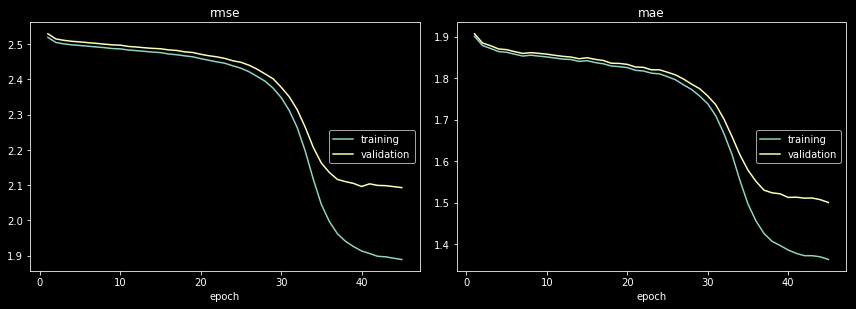

rmse:
training   (min:    1.889, max:    2.519, cur:    1.889)
validation (min:    2.093, max:    2.529, cur:    2.093)

mae:
training   (min:    1.363, max:    1.901, cur:    1.363)
validation (min:    1.501, max:    1.907, cur:    1.501)
CPU times: user 1min 50s, sys: 21.1 s, total: 2min 11s
Wall time: 1min 37s


In [42]:
%%time
fm = train_mcmc_fm(X_train, y_train, X_test, y_test, n_iter=500, rank=10, init_stdev=1e-3)

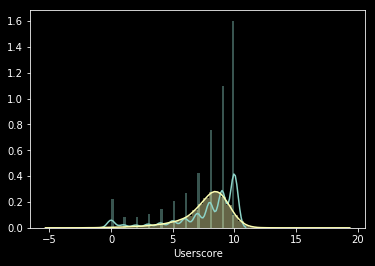

In [43]:
y_pred = fm.predict(X_test)

sns.distplot(y_test);
sns.distplot(y_pred);

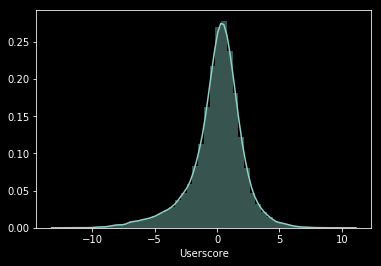

In [44]:
sns.distplot(y_test - y_pred);

In [45]:
np.sqrt(mean_squared_error(fm.predict(X_test) , y_test))

2.093210660305973

## Preparing data

In [46]:
X_train.shape[1]

16390

In [47]:
used_comments_df['Title_label_ID'].unique().size

2142

In [48]:
matrix_data = (used_comments_df['Userscore'], (used_comments_df['Username_label_ID'], used_comments_df['Title_label_ID']))
n_rows = matrix_data[1][0].max() + 1
n_cols = matrix_data[1][1].max() + 1
n_rows, n_cols

(14226, 2142)

In [49]:
n_rows + n_cols

16368

In [50]:
ratings_matrix = scipy.sparse.csr_matrix(matrix_data, shape=(n_rows, n_cols))

In [51]:
ratings_dict = {
  'The Witcher 3: Wild Hunt': 10,
  'Grand Theft Auto: Vice City': 10,
  'Diablo II: Lord of Destruction': 6,
  'Medieval II: Total War': 8,
  'Gothic': 7,
  'Age of Empires II: The Conquerors Expansion': 9,
  'Age of Mythology': 9,
  'Planescape: Torment': 10,
  'Deus Ex': 9,
  'Fallout' : 10,
  'Fallout 2': 10,
  'Fallout 3': 5,
  "Sid Meier's Civilization II": 9,
  'Antichamber': 9,
  'FIFA Soccer 11': 2,
  'The Sims': 1,
  "Baldur's Gate II: Shadows of Amn": 8,
  'Call of Duty 2': 7,
  'Darwinia': 9,
  'Starcraft': 9,
  'Tiger Woods PGA Tour 2004': 1,
  'Madden NFL 2004': 1,
  'Colin McRae Rally 2.0': 2
}

In [52]:
rated_titles = pd.Series(list(ratings_dict.keys()))

In [53]:
rated_titles

0                        The Witcher 3: Wild Hunt
1                     Grand Theft Auto: Vice City
2                  Diablo II: Lord of Destruction
3                          Medieval II: Total War
4                                          Gothic
5     Age of Empires II: The Conquerors Expansion
6                                Age of Mythology
7                             Planescape: Torment
8                                         Deus Ex
9                                         Fallout
10                                      Fallout 2
11                                      Fallout 3
12                    Sid Meier's Civilization II
13                                    Antichamber
14                                 FIFA Soccer 11
15                                       The Sims
16               Baldur's Gate II: Shadows of Amn
17                                 Call of Duty 2
18                                       Darwinia
19                                      Starcraft


In [54]:
title_ids = title_le.transform(rated_titles)

In [55]:
ratings = list(ratings_dict.values())

In [56]:
my_ratings = scipy.sparse.csr_matrix((ratings, (np.zeros_like(ratings), title_ids)), shape=(1, ratings_matrix.shape[1]))

In [57]:
from sklearn.metrics.pairwise import cosine_similarity

In [58]:
user_similarities = cosine_similarity(ratings_matrix, my_ratings)

In [59]:
n_similar = 10
similar_user_indices = user_similarities.argsort(axis=0)[::-1][:n_similar,0]

In [60]:
similar_user_matrix_data = (user_similarities[similar_user_indices][:,0], (np.zeros((n_similar,)), similar_user_indices))
similar_user_encoding = scipy.sparse.csr_matrix(similar_user_matrix_data, shape=(1, n_rows))

In [61]:
similar_user_encoding

<1x14226 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in Compressed Sparse Row format>

In [62]:
game_encoding_matrix = scipy.sparse.spdiags(np.ones((n_cols,)), diags=0, m=n_cols, n=n_cols)

In [63]:
similar_user_encoding

<1x14226 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in Compressed Sparse Row format>

In [64]:
X_user_encoding = scipy.sparse.vstack([similar_user_encoding for __ in range(n_cols)])

In [65]:
X_mine = scipy.sparse.hstack([X_user_encoding, game_encoding_matrix])

In [66]:
X_mine.shape

(2142, 16368)

In [67]:
copied_game_info_df = game_info_df.copy()
copied_game_info_df['Username_label_ID'] = 0
copied_game_info_df = copied_game_info_df.drop_duplicates(subset=['Title'])

In [68]:
copied_game_info_df.shape

(2142, 10)

In [69]:
X_mine_features = vectorizer.transform(copied_game_info_df)

In [70]:
X_mine_features.shape

(2142, 16390)

In [71]:
X_user_encoding.shape

(2142, 14226)

In [72]:
X_user_encoding

<2142x14226 sparse matrix of type '<class 'numpy.float64'>'
	with 21420 stored elements in Compressed Sparse Row format>

In [73]:
X_mine_features[:, :X_user_encoding.shape[1]] = X_user_encoding

/home/kuba/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [74]:
fm_predicted_ratings = fm.predict(X_mine_features)
fm_predicted_ratings = fm_predicted_ratings / fm_predicted_ratings.max() * 10

In [75]:
lin_reg_predicted_ratings = lin_reg.predict(X_mine_features)
lin_reg_predicted_ratings = lin_reg_predicted_ratings / lin_reg_predicted_ratings.max() * 10

In [76]:
predicted_ratings_df = pd.DataFrame({'LinScore': lin_reg_predicted_ratings, 'FMScore': fm_predicted_ratings, 'Title': copied_game_info_df['Title']}).sort_values(by='FMScore', ascending=False)

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

extra_trees = ExtraTreesRegressor(n_estimators=25, n_jobs=-1)

In [77]:
mine_ratings_df = predicted_ratings_df[predicted_ratings_df['Title'].isin(ratings_dict.keys())].sort_values(by='Title')

In [78]:
from  operator import itemgetter
mine_ratings_df['MyScore'] = list(map(itemgetter(1), sorted(ratings_dict.items(), key=itemgetter(0))))

In [79]:
mine_ratings_df.sort_values('FMScore', ascending=False)

,LinScore,FMScore,Title,MyScore
43,9.748689,9.340681,Grand Theft Auto: Vice City,10
107,9.785000,9.307673,The Witcher 3: Wild Hunt,10
1100,9.461384,9.301281,Fallout 2,10
410,9.639870,9.295630,Deus Ex,9
326,9.673225,9.282001,Planescape: Torment,10
727,9.528094,9.272861,Starcraft,9
917,9.449675,9.237623,Diablo II: Lord of Destruction,6
78,9.535076,9.234668,Madden NFL 2004,1
41,9.806646,9.227482,Baldur's Gate II: Shadows of Amn,8
706,9.483030,9.222832,Age of Empires II: The Conquerors Expansion,9


In [80]:
scipy.stats.spearmanr(mine_ratings_df['FMScore'], mine_ratings_df['MyScore'])

SpearmanrResult(correlation=0.5438770572774595, pvalue=0.007304533999486648)

In [81]:
scipy.stats.spearmanr(mine_ratings_df['LinScore'], mine_ratings_df['MyScore'])

SpearmanrResult(correlation=0.4752617699029377, pvalue=0.021912743000655214)

%%time
extra_trees.fit(X_train.toarray(), y_train)

y_pred_et= extra_trees.predict(X_test.toarray())
print(np.sqrt(mean_squared_error(y_pred_et , y_test)))